In [ ]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os


load_dotenv()
ow_key = os.getenv('ow_key')

In [19]:
df_ip = pd.read_csv('data/inverter_plants.csv')

# Fix NaN plant_address values to 'Gazipur' for consistency
df_ip['plant_address'] = df_ip['plant_address'].fillna('Gazipur')

df_ip['plant_number'] = df_ip.index + 1

df = df_ip[['plant_id', 'plant_name', 'plant_address', 'plant_capacity', 'plant_number']]

df

,plant_id,plant_name,plant_address,plant_capacity,plant_number
0,15848107,DGL (GGI),Gazipur,1280.40,1
1,1535729,SOLshare LM Tower,Dhaka,4.25,2
2,1535728,BHC,Dhaka,15.66,3
3,11811249,ACCL (GGI),Gazipur,285.12,4
4,11605154,NAL (GGI),Gazipur,227.04,5
5,12018942,ACML (GGI),Gazipur,525.36,6
6,11701955,CAL (GGI),Gazipur,522.72,7
7,11838318,HKL (GGI),Gazipur,269.28,8
8,1535726,Unilever Sales Depot Bogura,Bogura,39.60,9
9,9977156,KCL (SOLshare),Narayangang,249.20,10


In [20]:
df_day = pd.read_csv('data/inverter_daily_generation_logs.csv')
df_day = df_day.merge(df, on='plant_id', how='left')

plant_daylist = df_day['plant_name'].unique().tolist()
adress_daylist = df_day['plant_address'].unique().tolist()

df_day['generation_date'].min(), df_day['generation_date'].max(), adress_daylist

('2022-02-11 08:00:00.000000 UTC',
 '2025-10-22 18:00:00.000000 UTC',
 ['Gazipur', 'Rajshahi', 'Bogura', 'Dhaka', 'Narayangang'])

In [21]:
# Remove " , " from the value in generation_amount :
df_day['generation_amount'] = df_day['generation_amount'].astype(str).str.replace(',', '')

# Transform "generation_amount" value to float
df_day['generation_amount'] = df_day['generation_amount'].astype(float)

df_day['generation_date'] = pd.to_datetime(df_day['generation_date'])
df_day['date'] = df_day['generation_date'].dt.date

In [22]:
df_gazipur = df_day[df_day['plant_address'] == 'Gazipur']
gazipur_plant_list = df_gazipur['plant_name'].unique().tolist()
df_gazipur = df_gazipur[['date', 'generation_amount', 'plant_capacity', 'plant_name']]
df_gazipur['date'].min(), df_gazipur['date'].max(), (df_gazipur['date'].max() - df_gazipur['date'].min())


(datetime.date(2023, 11, 21),
 datetime.date(2025, 10, 22),
 datetime.timedelta(days=701))

In [23]:
for i in gazipur_plant_list:
    df_temp = df_gazipur[df_gazipur['plant_name'] == i]

    start = df_temp['date'].min()
    end = df_temp['date'].max()

    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    days = (end_dt - start_dt).days
    data_point = len(df_temp)

    print(i)
    print(f'days = {days}')
    print(f'data_point = {data_point}')
    print(start)
    print(end)
    print('\n')


ACCL (GGI)
days = 689
data_point = 509
2023-12-03
2025-10-22


ACML (GGI)
days = 617
data_point = 598
2024-02-13
2025-10-22


CAL (GGI)
days = 695
data_point = 656
2023-11-27
2025-10-22


DGL (GGI)
days = 113
data_point = 91
2025-07-01
2025-10-22


HKL (GGI)
days = 675
data_point = 645
2023-12-17
2025-10-22


NAL (GGI)
days = 701
data_point = 633
2023-11-21
2025-10-22




In [ ]:
df_gazi_weather = pd.read_csv('open_data/gazipur_weather.csv')

df_gazi_weather = df_gazi_weather[['dt_iso', 'temp', 'visibility', 'temp_min', 'temp_max', 'rain_1h', 'clouds_all']]

df_gazi_weather['date'] = pd.to_datetime(df_gazi_weather['dt_iso'].str.replace(' +0000 UTC', '', regex=False), errors='coerce').dt.date

df_gazi_weather = df_gazi_weather.groupby('date').agg({
    'temp': 'mean',
    'temp_min': 'min',
    'temp_max': 'max',
    'rain_1h': 'sum',
    'clouds_all': 'sum'
})

df_gazipur = df_gazipur.merge(df_gazi_weather, on='date', how='left')
df_gazipur

,date,generation_amount,plant_capacity,plant_name,temp,temp_min,temp_max,rain_1h,clouds_all
0,2025-10-22,159.600,285.12,ACCL (GGI),27.872917,23.05,33.54,0.00,325
1,2025-10-22,598.100,525.36,ACML (GGI),27.872917,23.05,33.54,0.00,325
2,2025-10-22,1007.800,522.72,CAL (GGI),27.872917,23.05,33.54,0.00,325
3,2025-10-22,3709.400,1280.40,DGL (GGI),27.872917,23.05,33.54,0.00,325
4,2025-10-22,979.300,269.28,HKL (GGI),27.872917,23.05,33.54,0.00,325
...,...,...,...,...,...,...,...,...,...
3127,2025-05-02,1551.700,525.36,ACML (GGI),27.680000,22.70,33.15,1.79,1046
3128,2025-04-28,70.532,525.36,ACML (GGI),25.258750,20.63,29.46,5.02,1744
3129,2025-04-26,185.562,525.36,ACML (GGI),30.541250,25.46,35.34,0.00,1520
3130,2025-04-27,819.131,525.36,ACML (GGI),29.349167,25.01,34.64,0.00,1415


In [25]:
ACCL_df = df_gazipur[df_gazipur['plant_name'] == 'ACCL (GGI)']
ACML_df = df_gazipur[df_gazipur['plant_name'] == 'ACML (GGI)']
CAL_df = df_gazipur[df_gazipur['plant_name'] == 'CAL (GGI)']
HKL_df = df_gazipur[df_gazipur['plant_name'] == 'HKL (GGI)']
NAL_df = df_gazipur[df_gazipur['plant_name'] == 'NAL (GGI)']

In [26]:
# Fix for duplicate 'date' issue before reindexing

# Remove duplicate entries for each date, keeping the first occurrence
ACCL_df = ACCL_df.sort_values('date').drop_duplicates(subset='date', keep='first')

# Create a full date range
full_dates = pd.date_range(start=ACCL_df['date'].min(), end=ACCL_df['date'].max(), freq='D')

# Set date as index and reindex to include all dates in the range
ACCL_df = ACCL_df.set_index('date').reindex(full_dates)

# Fill constant columns
ACCL_df['plant_capacity'] = ACCL_df['plant_capacity'].iloc[0]
ACCL_df['plant_name'] = ACCL_df['plant_name'].iloc[0]

# Prepare final dataframe
ACCL_df = ACCL_df.rename_axis('date').reset_index()

In [27]:
# Fix for duplicate 'date' issue before reindexing

# Remove duplicate entries for each date, keeping the first occurrence
ACML_df = ACML_df.sort_values('date').drop_duplicates(subset='date', keep='first')

# Create a full date range
full_dates = pd.date_range(start=ACML_df['date'].min(), end=ACML_df['date'].max(), freq='D')

# Set date as index and reindex to include all dates in the range
ACML_df = ACML_df.set_index('date').reindex(full_dates)

# Fill constant columns
ACML_df['plant_capacity'] = ACML_df['plant_capacity'].iloc[0]
ACML_df['plant_name'] = ACML_df['plant_name'].iloc[0]

# Prepare final dataframe
ACML_df = ACML_df.rename_axis('date').reset_index()

In [28]:
# Fix for duplicate 'date' issue before reindexing

# Remove duplicate entries for each date, keeping the first occurrence
CAL_df = CAL_df.sort_values('date').drop_duplicates(subset='date', keep='first')

# Create a full date range
full_dates = pd.date_range(start=CAL_df['date'].min(), end=CAL_df['date'].max(), freq='D')

# Set date as index and reindex to include all dates in the range
CAL_df = CAL_df.set_index('date').reindex(full_dates)

# Fill constant columns
CAL_df['plant_capacity'] = CAL_df['plant_capacity'].iloc[0]
CAL_df['plant_name'] = CAL_df['plant_name'].iloc[0]

# Prepare final dataframe
CAL_df = CAL_df.rename_axis('date').reset_index()

In [29]:
# Fix for duplicate 'date' issue before reindexing

# Remove duplicate entries for each date, keeping the first occurrence
HKL_df = HKL_df.sort_values('date').drop_duplicates(subset='date', keep='first')

# Create a full date range
full_dates = pd.date_range(start=HKL_df['date'].min(), end=HKL_df['date'].max(), freq='D')

# Set date as index and reindex to include all dates in the range
HKL_df = HKL_df.set_index('date').reindex(full_dates)

# Fill constant columns
HKL_df['plant_capacity'] = HKL_df['plant_capacity'].iloc[0]
HKL_df['plant_name'] = HKL_df['plant_name'].iloc[0]

# Prepare final dataframe
HKL_df = HKL_df.rename_axis('date').reset_index()

In [30]:
# Fix for duplicate 'date' issue before reindexing

# Remove duplicate entries for each date, keeping the first occurrence
NAL_df = NAL_df.sort_values('date').drop_duplicates(subset='date', keep='first')

# Create a full date range
full_dates = pd.date_range(start=NAL_df['date'].min(), end=NAL_df['date'].max(), freq='D')

# Set date as index and reindex to include all dates in the range
NAL_df = NAL_df.set_index('date').reindex(full_dates)

# Fill constant columns
NAL_df['plant_capacity'] = NAL_df['plant_capacity'].iloc[0]
NAL_df['plant_name'] = NAL_df['plant_name'].iloc[0]

# Prepare final dataframe
NAL_df = NAL_df.rename_axis('date').reset_index()

In [31]:
NAL_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               702 non-null    datetime64[ns]
 1   generation_amount  627 non-null    float64       
 2   plant_capacity     702 non-null    float64       
 3   plant_name         702 non-null    object        
 4   temp               627 non-null    float64       
 5   temp_min           627 non-null    float64       
 6   temp_max           627 non-null    float64       
 7   rain_1h            627 non-null    float64       
 8   clouds_all         627 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 49.5+ KB


In [47]:
NAL_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               702 non-null    datetime64[ns]
 1   generation_amount  627 non-null    float64       
 2   plant_capacity     702 non-null    float64       
 3   plant_name         702 non-null    object        
 4   temp               627 non-null    float64       
 5   temp_min           627 non-null    float64       
 6   temp_max           627 non-null    float64       
 7   rain_1h            627 non-null    float64       
 8   clouds_all         627 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 49.5+ KB


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

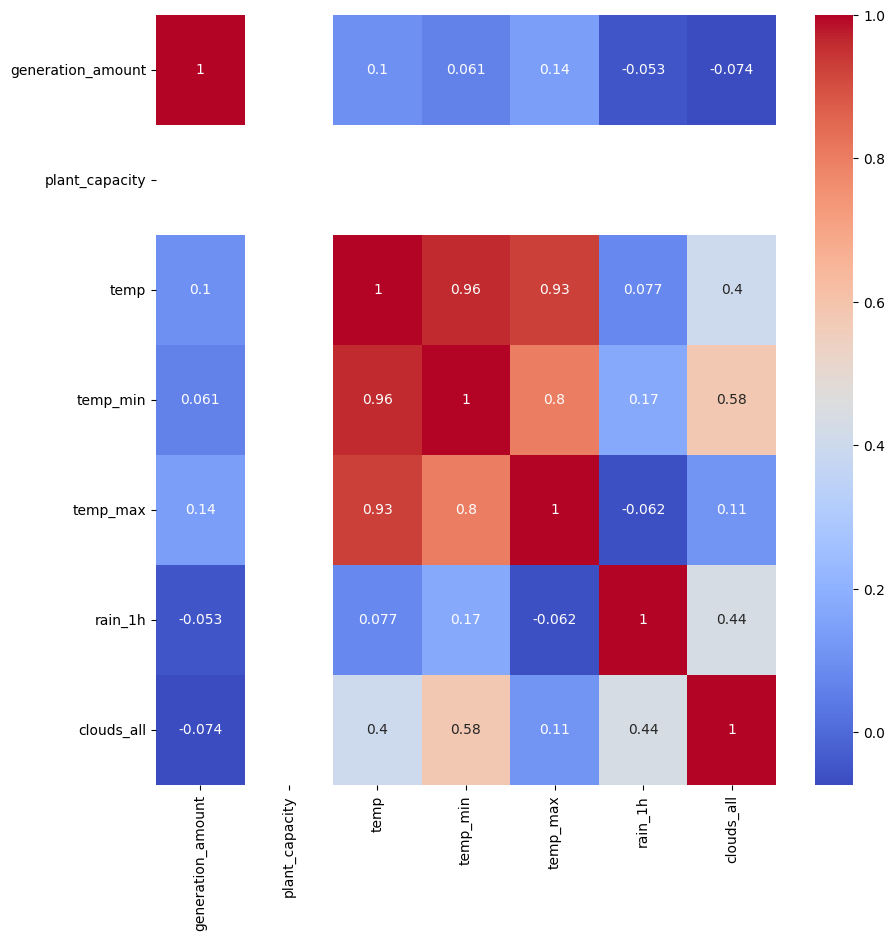

In [ ]:
plt.figure(figsize = (10, 10))

sns.heatmap(
    NAL_df.corr(),
    cmap = 'coolwarm',
    annot = True,
    annot_kws = {"size": 10}
)

In [46]:
# Fixes: drop non-numeric columns, then drop rows with NaN in features or target so scikit-learn works

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Drop non-numeric columns and generate features/target
drop_cols = ['date', 'plant_name', 'generation_amount']
X = NAL_df.drop(columns=drop_cols)
y = NAL_df['generation_amount']

# Combine features and target to drop *any* row with NaN in either
joint = X.copy()
joint['generation_amount'] = y
joint = joint.dropna(subset=X.columns.tolist() + ['generation_amount'])

# Re-extract cleaned X and y
X = joint.drop(columns=['generation_amount'])
y = joint['generation_amount']

# Split data into train/test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit regression
reg = LinearRegression().fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)

# Output scores and head of splits
print(f"Train R^2: {train_score:.3f}, Test R^2: {test_score:.3f}")

# Display head of train and test sets (joined to their y values)
train_df = X_train.copy()
train_df['generation_amount'] = y_train
test_df = X_test.copy()
test_df['generation_amount'] = y_test

train_df.head(), test_df.head()

Train R^2: 0.020, Test R^2: 0.001


(     plant_capacity       temp  temp_min  temp_max  rain_1h  clouds_all  \
 386          227.04  17.825417     14.27     24.36     0.00       502.0   
 14           227.04  23.247083     21.33     25.99     0.00      2074.0   
 120          227.04  22.040690     19.13     24.98     9.78      2380.0   
 130          227.04  27.601250     24.88     32.98     0.39      1371.0   
 545          227.04  27.971154     25.53     32.39    29.29      1679.0   
 
      generation_amount  
 386            205.376  
 14             174.464  
 120            427.229  
 130            680.858  
 545            564.795  ,
      plant_capacity       temp  temp_min  temp_max  rain_1h  clouds_all  \
 654          227.04  30.266250     26.98     33.75     0.37       938.0   
 664          227.04  27.015862     25.18     29.98     9.40      2256.0   
 624          227.04  28.358000     25.98     31.17     0.56      1975.0   
 257          227.04  29.315417     25.98     32.98     0.00      1351.0   
 548 